In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
data = pd.read_csv(r'.\input\train_10folds.csv')
data

,MaxPartialCharge,FpDensityMorgan2,BCUT2D_CHGLO,BCUT2D_MRHI,PEOE_VSA12,PEOE_VSA6,SMR_VSA3,SlogP_VSA3,SlogP_VSA8,EState_VSA6,NumHAcceptors,NumSaturatedCarbocycles,fr_bicyclic,TARGET,Kfold
0,0.232165,2.055556,-2.414188,6.375148,5.879988,11.600940,30.133278,11.343745,33.454659,6.196844,10,0,2,1.0,8
1,0.313409,1.155172,-2.211123,7.894021,0.000000,101.109334,4.899910,51.033142,6.076020,62.378411,10,0,0,0.0,9
2,0.394239,1.740741,-2.156618,6.360204,0.000000,17.907236,0.000000,9.589074,0.000000,31.127988,5,0,0,0.0,3
3,0.259309,1.789474,-1.979236,6.347147,5.824404,28.358543,15.124620,0.000000,22.842031,42.725522,4,0,0,0.0,5
4,0.326721,1.804878,-2.225746,9.103009,0.000000,88.440639,9.883888,22.616778,27.751393,12.272864,5,0,2,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,0.157227,1.928571,-2.406681,7.927002,0.000000,35.334614,9.967957,9.837253,11.257379,24.395945,7,0,0,0.0,6
2735,0.152046,1.958333,-2.386793,6.432995,0.000000,42.258351,9.967957,0.000000,11.257379,12.263211,5,0,0,1.0,2
2736,0.339242,1.900000,-2.136891,6.311472,6.792942,11.600940,0.000000,17.822241,10.969244,32.046576,6,0,2,0.0,5
2737,0.409243,2.000000,-2.396237,7.800537,0.000000,17.667307,14.699729,4.736863,0.000000,4.899910,4,0,0,0.0,8


In [4]:
data['TARGET'].value_counts()

0.0    1771
1.0     968
Name: TARGET, dtype: int64

In [5]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.iloc[:,:-1].copy()
    labels = df.pop('TARGET')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.iloc[:,:-1].items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [6]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)
    
    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [7]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    
    # create a layer that turns integer values into integer indices.
    index = layers.IntegerLookup(max_tokens=max_tokens)
    
    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    
    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    
    return lambda feature: encoder(index(feature))

In [8]:
fold = 0
train = data[data.Kfold != fold].reset_index(drop=True)
# get validation data using folds
valid = data[data.Kfold == fold].reset_index(drop=True)

In [9]:
numerical_features = ['MaxPartialCharge', 'FpDensityMorgan2', 'BCUT2D_CHGLO', 'BCUT2D_MRHI',
       'PEOE_VSA12', 'PEOE_VSA6', 'SMR_VSA3', 'SlogP_VSA3', 'SlogP_VSA8', 'EState_VSA6']

categorical_features = ['NumHAcceptors', 'NumSaturatedCarbocycles', 'fr_bicyclic']

In [10]:
batch_size = 16
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(valid, shuffle=False, batch_size=batch_size)

In [11]:
len(val_ds)

18

In [12]:
len(train_ds)

155

In [13]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_features:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [14]:
len(data['NumHAcceptors'].unique())

20

In [15]:
hacc_col = tf.keras.Input(shape=(1,), name='NumHAcceptors', dtype='int64')

encoding_layer = get_category_encoding_layer(name='NumHAcceptors',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=20)
encoded_hacc_col = encoding_layer(hacc_col)

all_inputs.append(hacc_col)
encoded_features.append(encoded_hacc_col)

In [16]:
len(data['NumSaturatedCarbocycles'].unique())

5

In [17]:
scc_col = tf.keras.Input(shape=(1,), name='NumSaturatedCarbocycles', dtype='int64')

encoding_layer = get_category_encoding_layer(name='NumSaturatedCarbocycles',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_scc_col = encoding_layer(scc_col)

all_inputs.append(scc_col)
encoded_features.append(encoded_scc_col)

In [18]:
len(data['fr_bicyclic'].unique())

10

In [19]:
fbc_col = tf.keras.Input(shape=(1,), name='fr_bicyclic', dtype='int64')

encoding_layer = get_category_encoding_layer(name='fr_bicyclic',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=10)
encoded_fbc_col = encoding_layer(fbc_col)
all_inputs.append(fbc_col)
encoded_features.append(encoded_fbc_col)

In [20]:
hparams_df = pd.DataFrame()

# Model Training

In [21]:
hparams = {
'Experiment' : ['exp_8'],
'hidden_layer1' : [16],
'hidden_layer2' : [64],
'hidden_layer3' : [128],
'hidden_layer4' : [256],
'hidden_layer5' : [32],
'hidden_layer6' : [8],
'hidden_layer7' : [0],
'hidden_layer8' : [0],
'hidden_layer9' : [0],
'hidden_layer10' : [0],
'initializer' : [tf.keras.initializers.HeNormal()],
'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.001)],
'dropout' : [0.1],
'batch_size' : [batch_size],
'epochs' : [100]
}  

In [22]:
hparams_df1 = pd.DataFrame(hparams)
hparams_df1 

,Experiment,hidden_layer1,hidden_layer2,hidden_layer3,hidden_layer4,hidden_layer5,hidden_layer6,hidden_layer7,hidden_layer8,hidden_layer9,hidden_layer10,initializer,optimizer,dropout,batch_size,epochs
0,exp_8,16,64,128,256,32,8,0,0,0,0,<keras.initializers.initializers_v2.HeNormal o...,<keras.optimizer_v2.adam.Adam object at 0x0000...,0.1,16,100


In [23]:
def AnnClassifier(all_inputs, encoded_features):
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer1'][0], activation="relu", 
                              kernel_initializer=hparams['initializer'][0])(all_features)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.Dropout(hparams['dropout'][0])(x)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer2'][0], activation="relu",
                             kernel_initializer=hparams['initializer'][0])(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.Dropout(hparams['dropout'][0])(x)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer3'][0], activation="relu",
                             kernel_initializer=hparams['initializer'][0])(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.Dropout(hparams['dropout'][0])(x)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer4'][0], activation="relu",
                             kernel_initializer=hparams['initializer'][0])(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer5'][0], activation="relu",
                             kernel_initializer=hparams['initializer'][0])(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Dense(units=hparams['hidden_layer6'][0], activation="relu",
                             kernel_initializer=hparams['initializer'][0])(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(all_inputs, output)
    model.compile(optimizer = hparams['optimizer'][0], loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [25]:
logdir = r'.\\tensorboard_logs\\scalars\\fold_0\\' + hparams['Experiment'][0]
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,update_freq=1)

In [26]:
checkpoint_filepath = r'.\\model_checkpoints\\fold_0\\' + hparams['Experiment'][0]
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
ann = AnnClassifier(all_inputs, encoded_features)

ann.fit(train_ds, 
        epochs = hparams['epochs'][0], 
        validation_data = val_ds,
        callbacks=[early_stop, tensorboard_callback, model_checkpoint_callback])

Epoch 1/100
155/155 [==============================] - 23s 96ms/step - loss: 0.5008 - accuracy: 0.7594 - val_loss: 0.4085 - val_accuracy: 0.8431


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 2/100
155/155 [==============================] - 11s 72ms/step - loss: 0.3860 - accuracy: 0.8414 - val_loss: 0.3643 - val_accuracy: 0.8650


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 3/100
155/155 [==============================] - 11s 69ms/step - loss: 0.3567 - accuracy: 0.8450 - val_loss: 0.3166 - val_accuracy: 0.8759


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 4/100
155/155 [==============================] - 11s 73ms/step - loss: 0.3353 - accuracy: 0.8560 - val_loss: 0.3157 - val_accuracy: 0.8796


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 5/100
155/155 [==============================] - 13s 85ms/step - loss: 0.3301 - accuracy: 0.8613 - val_loss: 0.2892 - val_accuracy: 0.8869


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 6/100
155/155 [==============================] - 14s 93ms/step - loss: 0.3189 - accuracy: 0.8661 - val_loss: 0.3028 - val_accuracy: 0.8796
Epoch 7/100
155/155 [==============================] - 15s 94ms/step - loss: 0.2950 - accuracy: 0.8884 - val_loss: 0.2959 - val_accuracy: 0.8759
Epoch 8/100
155/155 [==============================] - 15s 99ms/step - loss: 0.3003 - accuracy: 0.8755 - val_loss: 0.2720 - val_accuracy: 0.8869
Epoch 9/100
155/155 [==============================] - 17s 108ms/step - loss: 0.2867 - accuracy: 0.8824 - val_loss: 0.2804 - val_accuracy: 0.8759
Epoch 10/100
155/155 [==============================] - 18s 113ms/step - loss: 0.2883 - accuracy: 0.8836 - val_loss: 0.2818 - val_accuracy: 0.8905


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 11/100
155/155 [==============================] - 19s 122ms/step - loss: 0.2819 - accuracy: 0.8913 - val_loss: 0.2632 - val_accuracy: 0.9088


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 12/100
155/155 [==============================] - 19s 121ms/step - loss: 0.2610 - accuracy: 0.8953 - val_loss: 0.2750 - val_accuracy: 0.9015
Epoch 13/100
155/155 [==============================] - 21s 133ms/step - loss: 0.2652 - accuracy: 0.8905 - val_loss: 0.2849 - val_accuracy: 0.8978
Epoch 14/100
155/155 [==============================] - 23s 145ms/step - loss: 0.2542 - accuracy: 0.9059 - val_loss: 0.2618 - val_accuracy: 0.9015
Epoch 15/100
155/155 [==============================] - 27s 173ms/step - loss: 0.2592 - accuracy: 0.9002 - val_loss: 0.2552 - val_accuracy: 0.9051
Epoch 16/100
155/155 [==============================] - 30s 191ms/step - loss: 0.2547 - accuracy: 0.9063 - val_loss: 0.2758 - val_accuracy: 0.8942
Epoch 17/100
155/155 [==============================] - 30s 195ms/step - loss: 0.2600 - accuracy: 0.8994 - val_loss: 0.2481 - val_accuracy: 0.9088
Epoch 18/100
155/155 [==============================] - 34s 222ms/step - loss: 0.2436 - accuracy: 0.8966 - val_loss: 0

INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 19/100
155/155 [==============================] - 22s 144ms/step - loss: 0.2483 - accuracy: 0.8974 - val_loss: 0.2410 - val_accuracy: 0.9088
Epoch 20/100
155/155 [==============================] - 34s 222ms/step - loss: 0.2415 - accuracy: 0.8998 - val_loss: 0.2591 - val_accuracy: 0.9161
Epoch 21/100
155/155 [==============================] - 45s 293ms/step - loss: 0.2396 - accuracy: 0.9010 - val_loss: 0.2463 - val_accuracy: 0.9124
Epoch 22/100
155/155 [==============================] - 128s 826ms/step - loss: 0.2335 - accuracy: 0.9071 - val_loss: 0.2618 - val_accuracy: 0.8978
Epoch 23/100
155/155 [==============================] - 113s 724ms/step - loss: 0.2330 - accuracy: 0.9103 - val_loss: 0.2409 - val_accuracy: 0.9088
Epoch 24/100
155/155 [==============================] - 112s 713ms/step - loss: 0.2337 - accuracy: 0.9140 - val_loss: 0.2256 - val_accuracy: 0.9161
Epoch 25/100
155/155 [==============================] - 112s 717ms/step - loss: 0.2241 - accuracy: 0.9132 - val_los

INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


INFO:tensorflow:Assets written to: .\\model_checkpoints\\fold_0\exp_8\assets


Epoch 27/100
155/155 [==============================] - 83s 539ms/step - loss: 0.2125 - accuracy: 0.9128 - val_loss: 0.2317 - val_accuracy: 0.9270
Epoch 28/100
155/155 [==============================] - 104s 669ms/step - loss: 0.2267 - accuracy: 0.9099 - val_loss: 0.2251 - val_accuracy: 0.9234
Epoch 29/100
155/155 [==============================] - 105s 673ms/step - loss: 0.2096 - accuracy: 0.9181 - val_loss: 0.2528 - val_accuracy: 0.8905
Epoch 30/100
155/155 [==============================] - 107s 684ms/step - loss: 0.2126 - accuracy: 0.9140 - val_loss: 0.2428 - val_accuracy: 0.9197
Epoch 31/100
155/155 [==============================] - 101s 648ms/step - loss: 0.2214 - accuracy: 0.9201 - val_loss: 0.2248 - val_accuracy: 0.9088
Epoch 32/100
155/155 [==============================] - 101s 653ms/step - loss: 0.2188 - accuracy: 0.9124 - val_loss: 0.2113 - val_accuracy: 0.9234
Epoch 33/100
155/155 [==============================] - 104s 664ms/step - loss: 0.2116 - accuracy: 0.9160 - val_l

In [28]:
hparams_df = pd.concat([hparams_df, hparams_df1])
hparams_df = hparams_df.reset_index(drop=True)
hparams_df

,Experiment,hidden_layer1,hidden_layer2,hidden_layer3,hidden_layer4,hidden_layer5,hidden_layer6,hidden_layer7,hidden_layer8,hidden_layer9,hidden_layer10,initializer,optimizer,dropout,batch_size,epochs
0,exp_7,16,64,128,32,32,8,0,0,0,0,<keras.initializers.initializers_v2.HeNormal o...,<keras.optimizer_v2.adam.Adam object at 0x0000...,0.1,16,100


In [29]:
model_loss = pd.DataFrame(ann.history.history) 

In [30]:
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.564642,0.725761,0.517631,0.784672
1,0.456784,0.795943,0.400193,0.839416
2,0.407168,0.819473,0.336427,0.857664
3,0.375653,0.834888,0.349394,0.854015
4,0.364730,0.835294,0.321512,0.879562
5,0.353003,0.849493,0.328931,0.872263
6,0.325574,0.864503,0.318617,0.886861
7,0.334291,0.859229,0.321477,0.875912
8,0.326739,0.870994,0.295180,0.879562
9,0.313568,0.875862,0.291637,0.879562


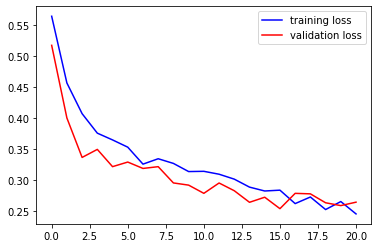

In [31]:
plt.plot(model_loss['loss'],'b', label='training loss')
plt.plot(model_loss['val_loss'],'r', label='validation loss')
plt.legend()

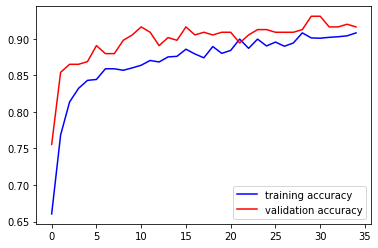

In [32]:
plt.plot(model_loss['accuracy'],'b', label='training accuracy')
plt.plot(model_loss['val_accuracy'],'r', label='validation accuracy')
plt.legend()

In [41]:
model_path = ".\\model_checkpoints\\fold_0\\exp_5"
reloaded_ann = tf.keras.models.load_model(model_path)

In [42]:
X_test = valid
y_test = valid.iloc[:,-2].values
X_test_ds = df_to_dataset(X_test, shuffle=False, batch_size=batch_size)

In [43]:
len(X_test_ds)

18

In [44]:
y_pred = reloaded_ann.predict(X_test_ds)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 

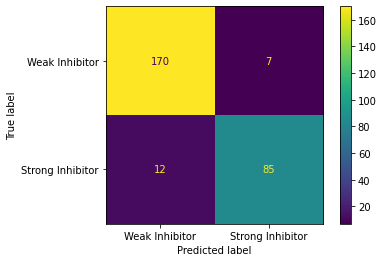

In [45]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = ['Weak Inhibitor', 'Strong Inhibitor'])
cmd.plot()

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       177
         1.0       0.92      0.88      0.90        97

    accuracy                           0.93       274
   macro avg       0.93      0.92      0.92       274
weighted avg       0.93      0.93      0.93       274



In [47]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.9183703185974722